# Kessler Rules model for Sorted Circles

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors,cm

## Setting up the Grids
Only work in 2-D case for now.

In [9]:
# Setting constants
nx = 5
nz = 10
dx,dz = 0.2,0.1
atm_thickness = 5

T_a = -40 #temperature of atmosphere
T_0 = 2 #Temperature of soil initially
h_stones = 1 # thickness of stone layer
porosity = 0.2 #porosity of soil (represented as fraction of void cells in fines domain)
rho_water = 1000 #density kg/m3
rho_fines = 1600 #density kg/m3

# Heat capacity and specific heat:
cp_fines = 800 #J/kg/C for dry sand
cp_water = 4186 #J/kg/C
cp_wet = 1480 #J/kg/C
L_fusion = 333.55*1000 #J/kg

# thermal diffusivities
kappa_fines = 1e-5 
kappa_stones = 1e-3
kappa_ice = 1e-7
kappa_atmosphere = 1e-7

In [10]:


#create initial arrays:
temp_arr = np.zeros((nz,nx)) #array for temperature
type_arr = np.zeros_like(temp_arr).astype('str')
kappa_arr = np.zeros_like(temp_arr) # array holding diffusivity of each cell

#set type array:
type_arr[:atm_thickness,:] = 'a'
type_arr[atm_thickness:atm_thickness+h_stones,:] = 's'
type_arr[atm_thickness+h_stones:,:] = 'f'

# add voids at random spaces based on type
n_voids = int(np.sum(type_arr == 'f')*porosity)
void_indx = [(np.random.randint(atm_thickness+h_stones,len(type_arr)),np.random.randint(0,len(type_arr[0]))) for _ in range(n_voids)]
for i in void_indx:
    type_arr[i] = 'v'

type_arr



array([['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['a', 'a', 'a', 'a', 'a'],
       ['s', 's', 's', 's', 's'],
       ['f', 'f', 'f', 'f', 'f'],
       ['v', 'v', 'f', 'f', 'v'],
       ['f', 'v', 'f', 'f', 'f'],
       ['f', 'f', 'f', 'f', 'f']], dtype='<U32')

In [47]:
def set_arrays(type_arr,diff_arr,temp_arr,heat_arr,kappa_atm,kappa_fines,kappa_stones,T_a,T_0,heat_initial):
    '''Set diffusivity, temperature and latent heat arrays for the next freezing cycle'''
    mapping_dict = {'a': [kappa_atm,T_a,0],'v':[kappa_atm,T_0,0],'f':[kappa_fines,T_0,heat_initial],'s':[kappa_stones,T_0,0]}
    for key in mapping_dict:
        diff_arr[type_arr == key] = mapping_dict[key][0]
        temp_arr[type_arr == key] = mapping_dict[key][1]
        heat_arr[type_arr == key] = mapping_dict[key][2]
    
    return diff_arr,temp_arr,heat_arr

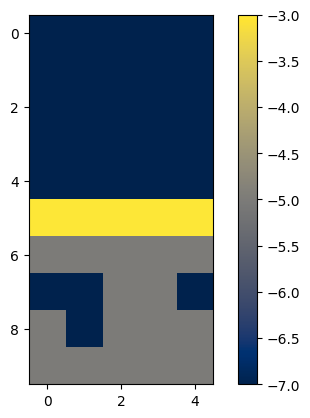

In [11]:
# set thermal diffusivity array:
kappa_arr[type_arr == 'a'] = kappa_atmosphere
kappa_arr[type_arr == 'v'] = kappa_atmosphere
kappa_arr[type_arr == 's'] = kappa_stones
kappa_arr[type_arr == 'f'] = kappa_fines

plt.imshow(np.log10(kappa_arr),cmap='cividis')
plt.colorbar();

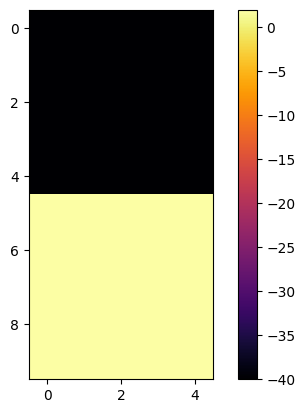

In [12]:
# set initial Temperature array:
temp_arr[type_arr=='a'] = T_a
temp_arr[type_arr !='a'] = T_0

plt.imshow(temp_arr,cmap='inferno')
plt.colorbar();

In [13]:
# pad each array to have a constant boundary
temp_arr_pad = np.pad(temp_arr,mode='edge',pad_width=1)
temp_arr_pad[-1,:] = -2

type_arr_pad = np.pad(type_arr,1,mode='constant',constant_values='b')

kappa_arr_pad = np.pad(kappa_arr,1,mode='edge')
print(type_arr_pad.shape)
type_arr_pad[1,6]

(12, 7)


'b'

In [14]:
kappa_arr_pad_original = kappa_arr_pad.copy()
type_arr_pad_original = type_arr_pad.copy()

## Temperature Diffusion
The Heat equation is given by:
$\frac{\partial T}{\partial t} = \kappa \nabla^2T  \\$
Discretised for 2 dimensions and using FTCS this gives 
$\Delta T_{i,j} = \kappa \Delta t (\frac{T_{i-1,j}^n - 2T_{i,j}^n+T_{i+1,j}^n}{\Delta x^2} + \frac{T_{i,j-1}^n - 2T_{i,j}^n+T_{i,j+1}^n}{\Delta z^2}$)

In [15]:
dt = min(dx**2/(8*kappa_stones),dz**2/(8*kappa_stones))
print(dt)

def solve_heat2D(T,type,kappa, dt=dt,dx=dx,dz=dz,nx=nx,nz=nz):
    dT_arr = np.zeros_like(T)
    for i in range(1, nx+1):
        for j in range(1,nz+1):
            if type[j,i] == 'a' or type[j,i] == 'b': #ignore atomsphere and boundary cells
                continue
            else:
                dTdx = (T[j,i-1] - 2*T[j,i] + T[j,i+1]) / (dx**2) # calculate T difference in  x
                dTdz = (T[j-1,i] - 2*T[j,i] + T[j+1,i]) / (dz**2) # calculate T difference in z
                
                dT_arr[j,i] = kappa[j,i]*dt*(dTdx+dTdz)

    return dT_arr

1.2500000000000002


### Testing diffusion equation on its own

In [16]:
temp_arr_pad_original = temp_arr_pad.copy()
nt = int(400000/dt)+1
print(nt)
for _ in range(nt):
    temp_arr_pad += solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad)

320000


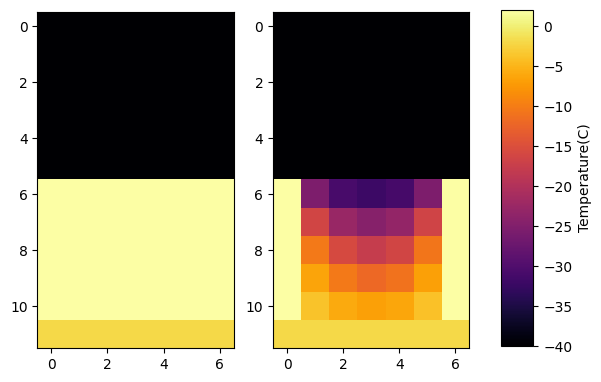

In [17]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(temp_arr_pad_original,cmap='inferno')
im = ax[1].imshow(temp_arr_pad,cmap='inferno')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im,cax=cbar_ax,label='Temperature(C)');

### Add Latent heat conversion

In [18]:
# Create array of amount of heat needed for full conversion of water to ice:
Q_needed = porosity*(dz*dx**2)*rho_water*L_fusion # Heat needed for a cell of all porous space filled by water

heat_arr_initial = np.zeros_like(temp_arr_pad)
heat_arr_initial[type_arr_pad=='f'] = Q_needed #set fines cells in heat array to the initial heat needed for fusion

In [19]:
def convert_T_to_heat(T,dz=dz,dx=dx,cp=cp_wet,porosity=porosity,rho_solid=rho_fines,rho_water=rho_water):
    mass = porosity*(dz*dx**2)*rho_water + (1-porosity)*(dz*dx**2)*rho_solid #calculate mass of whole cell
    return T*mass*cp

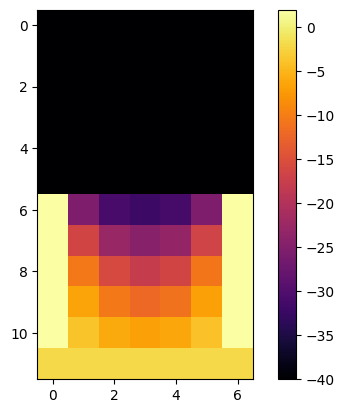

In [20]:
temp_arr_pad = temp_arr_pad_original.copy()
nt = int(400000/dt)+1
heat_arr = heat_arr_initial.copy()
for _ in range(nt):
    temp_change = solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad) #calculate change in Temperature

    for i in range(1, nx+1):
        for j in range(1,nz+1):
            new_temp = temp_arr_pad[j,i] + temp_change[j,i]
            if type_arr_pad[j,i] == 'f' and heat_arr[j,i] > 0: #only look at fines cells with heat remaining
                if new_temp <=0: # check if cell would go below zero
                    heat_arr[j,i] += convert_T_to_heat(new_temp) # 'freeze' part of water to stay at zero degrees
                    new_temp = 0
            
            temp_arr_pad[j,i] = new_temp


plt.imshow(temp_arr_pad,cmap='inferno')
plt.colorbar();

In [21]:
type_arr_pad

array([['b', 'b', 'b', 'b', 'b', 'b', 'b'],
       ['b', 'a', 'a', 'a', 'a', 'a', 'b'],
       ['b', 'a', 'a', 'a', 'a', 'a', 'b'],
       ['b', 'a', 'a', 'a', 'a', 'a', 'b'],
       ['b', 'a', 'a', 'a', 'a', 'a', 'b'],
       ['b', 'a', 'a', 'a', 'a', 'a', 'b'],
       ['b', 's', 's', 's', 's', 's', 'b'],
       ['b', 'f', 'f', 'f', 'f', 'f', 'b'],
       ['b', 'v', 'v', 'f', 'f', 'v', 'b'],
       ['b', 'f', 'v', 'f', 'f', 'f', 'b'],
       ['b', 'f', 'f', 'f', 'f', 'f', 'b'],
       ['b', 'b', 'b', 'b', 'b', 'b', 'b']], dtype='<U32')

## Implementing Rules for freezing:
Once a fines cell has full depleted it's latent heat 'reservoir', an ice cell is created and displaces the fine cell either into a void or an atmosphere cell. The probabillity for each is given by the greater of: $\\$
$P_{surf} = max(0,1-d_{surf}/d_s) \\$
$P_{void} = max(0,1-d_{void}/d_s)$

In [22]:
def cart_distance(p1,p2):
    '''Calculate the cartesian distance between two points (2D)'''
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def find_closest(x,z,target_val,search_arr):
    '''Find the closest cell of target_val value to the cell at [z,x] in search_arr and the distance between them'''
    valid = np.where(search_arr == target_val)
    valid = list(zip(valid[0],valid[1]))

    d = [cart_distance((x,z),v) for v in valid]
    if len(d) != 0:
        closest_idx = valid[np.where(d==min(d))[0][0]]
        distance = min(d)
    else: #if all space is filled
        closest_idx=None
        distance=None
    return closest_idx, distance

def find_newplace(old_coord,type_arr=type_arr_pad,ds=5,dv=5):
    ''' Find new location for a cell when displaced by an ice cell'''
    z,x = old_coord
    closest_atm, d_atm = find_closest(z,x,'a',type_arr)
    closest_void, d_void = find_closest(z,x,'v',type_arr)

    if closest_void == None or d_void == None:
        new_z,new_x = closest_atm
        return new_z,new_x
    
    P_surf = max(0,1-(d_atm/ds))
    P_void = max(0,1-(d_void/dv))

    if P_surf > P_void:
        new_z,new_x = closest_atm
    else:
        new_z,new_x = closest_void

    return new_z,new_x

def replace_cell(old_coord,new_coord,type_arr,diff_arr,fine_diff = kappa_fines,ice_diff=kappa_ice):
    '''Replace fines cell with ice particle and move fines to new cell and change diffusivity array'''
    #change old cell to ice cell:
    type_arr[old_coord] = 'i'
    diff_arr[old_coord] = ice_diff

    #change new cell:
    type_arr[new_coord] = 'f'
    diff_arr[new_coord] = fine_diff

    return type_arr,diff_arr
    

In [23]:
#setting up a test case
type_arr_pad_test = type_arr_pad.copy()
kappa_arr_pad_test = kappa_arr_pad.copy()
test_z = 8
test_x = 3
test_coord = (test_z,test_x)
type_arr_pad_test[test_coord] = 't'

print(type_arr_pad_test)
new_coord = find_newplace(test_coord,type_arr=type_arr_pad_test)
print(new_coord)
type_arr_pad_test,kappa_arr_pad_test = replace_cell((test_z,test_x),new_coord,type_arr_pad_test,kappa_arr_pad_test)
print(type_arr_pad_test)

[['b' 'b' 'b' 'b' 'b' 'b' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 's' 's' 's' 's' 's' 'b']
 ['b' 'f' 'f' 'f' 'f' 'f' 'b']
 ['b' 'v' 'v' 't' 'f' 'v' 'b']
 ['b' 'f' 'v' 'f' 'f' 'f' 'b']
 ['b' 'f' 'f' 'f' 'f' 'f' 'b']
 ['b' 'b' 'b' 'b' 'b' 'b' 'b']]
(8, 2)
[['b' 'b' 'b' 'b' 'b' 'b' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 'a' 'a' 'a' 'a' 'a' 'b']
 ['b' 's' 's' 's' 's' 's' 'b']
 ['b' 'f' 'f' 'f' 'f' 'f' 'b']
 ['b' 'v' 'f' 'i' 'f' 'v' 'b']
 ['b' 'f' 'v' 'f' 'f' 'f' 'b']
 ['b' 'f' 'f' 'f' 'f' 'f' 'b']
 ['b' 'b' 'b' 'b' 'b' 'b' 'b']]


## Combining Diffusion and fines movement
Combine diffusion, latent heat and movement of fines to have a full freezing cycle

In [24]:
# set up model run
temp_arr_pad = temp_arr_pad_original.copy()
heat_arr = heat_arr_initial.copy()
kappa_arr_pad = kappa_arr_pad_original.copy()
type_arr_pad = type_arr_pad_original.copy()
nt = int(400000/dt)+1

In [25]:
# model loop:
c = 0
for _ in range(nt):
    c+=1
    temp_change = solve_heat2D(temp_arr_pad,type_arr_pad,kappa_arr_pad) #calculate change in Temperature

    for i in range(1, nx+1):
        for j in range(1,nz+1):
            new_temp = temp_arr_pad[j,i] + temp_change[j,i]
            if type_arr_pad[j,i] == 'f' and heat_arr[j,i] > 0: #only look at fines cells with heat remaining
                if new_temp <=0: # check if cell would go below zero
                    heat_arr[j,i] += convert_T_to_heat(new_temp) # 'freeze' part of water to stay at zero degrees
                    new_temp = 0
                    if heat_arr[j,i] <= 0: #if all heat is used up replace fine with ice
                        new_coord = find_newplace((j,i),type_arr_pad)
                        type_arr_pad,kappa_arr_pad = replace_cell((j,i),new_coord,type_arr_pad,kappa_arr_pad)
            
            temp_arr_pad[j,i] = new_temp
    if np.all(heat_arr <=0):
        break
print(f'Timesteps taken:{c}')

Timesteps taken:44359


In [26]:
conversion_dict = {'a': 1,'b':0,'f':2,'s':3,'i':4}
viz_arr = type_arr_pad.copy()
for i in range(0,type_arr_pad.shape[0]):
    for j in range(0,type_arr_pad.shape[1]):
        viz_arr[i,j] = conversion_dict[type_arr_pad[i,j]]
viz_arr = viz_arr.astype('int')
viz_arr

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 2, 2, 0],
       [0, 2, 2, 2, 2, 2, 0],
       [0, 2, 2, 2, 2, 2, 0],
       [0, 3, 3, 3, 3, 3, 0],
       [0, 4, 4, 4, 4, 4, 0],
       [0, 2, 2, 4, 4, 2, 0],
       [0, 4, 2, 4, 4, 4, 0],
       [0, 4, 4, 4, 4, 4, 0],
       [0, 0, 0, 0, 0, 0, 0]])

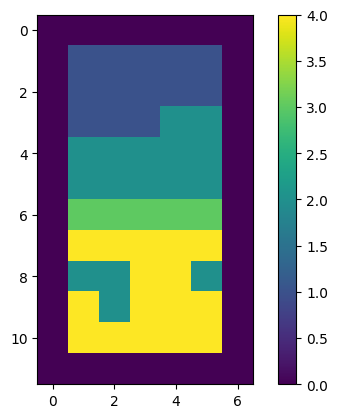

In [27]:
plt.imshow(viz_arr)
plt.colorbar();

In [28]:
cmap = (colors.ListedColormap(['black','white','brown','gray','lightblue'])
        .with_extremes(over='0', under='1'))

bounds = [0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

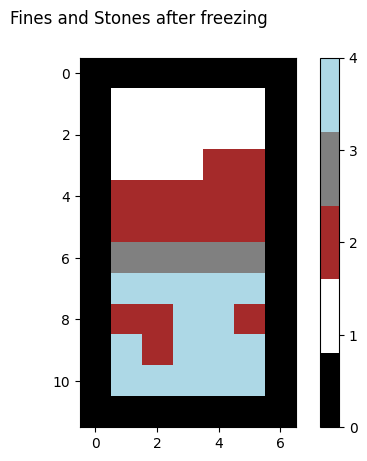

In [32]:
plt.imshow(viz_arr,cmap=cmap)
plt.suptitle('Fines and Stones after freezing')
plt.colorbar(ticks=bounds);

## Thawing cycle
1. Removing ice cells
2. Fines falling through stone
3. Expansion and incorporation of void space

In [ ]:
#